<a href="https://colab.research.google.com/github/stanfordio/wikipedia-notebook/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wikipedia Scanner

Created for INTLPOL268D at Stanford University by Team Wikipedia.

### License

Copyright Stanford University and R. Miles McCain (2020).

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0).

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### How to Use

Enter your query in the search box to the right, and select the appropriate sort order. Selecting `incoming_links_asc` will yield less popular pages; it's worth experimenting with the options to find what works best for your investigation.

In [ ]:
#@title Search Parameters
query = "American \"chief of staff\" incategory:living_people" #@param {type:"string"}
sort_order = 'incoming_links_asc' #@param ["create_timestamp_desc", "incoming_links_asc", "random", "none", "relevance", "last_edit_desc"]

## Setup

In [ ]:
%pip install pandas numpy requests seaborn matplotlib tqdm
import requests
import functools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from datetime import datetime, timedelta
from dateutil.parser import parse as dateparse
from tqdm.gui import tqdm

In [ ]:
@functools.lru_cache()
def __search_wikipedia(query):
  """Internal function for searching Wikipedia and getting the raw results"""

  # Any way to get recent number of edits?
  PARAMS = {
    "action": "query",
    "format": "json",
    "prop": "flagged|info|pageprops|description",
    "generator": "search",
    "redirects": 1,
    "converttitles": 1,
    "pvipmetric": "pageviews",
    "gsrsearch": query,
    "gsrsort": sort_order,
    "gsrlimit": 100,
  }

  return requests.get("https://en.wikipedia.org/w/api.php", params=PARAMS).json()

@functools.lru_cache()
def __page_metadata(page_name):
  """Internal function for getting the revision history of an individual page."""

  PARAMS = {
    "action": "query",
    "format": "json",
    "prop": "flagged|info|pageassessments|pageprops|revisions|pageviews",
    "titles": page_name,
    "redirects": 1,
    "rvlimit": "max",
    "converttitles": 1,
  }

  resp = requests.get("https://en.wikipedia.org/w/api.php", params=PARAMS).json()["query"]["pages"].values()
  page_data = list(resp)[0]
  return {
      "revisions": page_data["revisions"],
      "pageviews": page_data["pageviews"]
  }

In [ ]:
def search(query):
  print("Searching for pages...")
  results = __search_wikipedia(query)
  pages = results["query"]["pages"].values()

  print("Loading revision histories...")
  for page in tqdm(pages):      
    # Get number of recent edits, pageviews
    page_metadata = __page_metadata(page["title"])
    page["revisions"] = page_metadata["revisions"]
    page["recent_revisions"] = 0
    for revision in page["revisions"]:
      if dateparse(revision["timestamp"]).replace(tzinfo=None) > datetime.utcnow() - timedelta(days=30):
        page["recent_revisions"] += 1

    if "pageviews" in page_metadata:
      page["pageview_avg"] = statistics.mean([value if value is not None else 0 for value in page_metadata["pageviews"].values()])

    page["link"] = f"https://en.wikipedia.org/?curid={page['pageid']}"

  return pd.DataFrame(data=pages)

## Querying, Loading, and Processing Data

Searching for pages...
Loading revision histories...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: GUI is experimental/alpha
  import sys


'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>pageid</th>\n      <th>ns</th>\n      <th>title</th>\n      <th>index</th>\n      <th>contentmodel</th>\n      <th>pagelanguage</th>\n      <th>pagelanguagehtmlcode</th>\n      <th>pagelanguagedir</th>\n      <th>touched</th>\n      <th>lastrevid</th>\n      <th>length</th>\n      <th>pageprops</th>\n      <th>revisions</th>\n      <th>recent_revisions</th>\n      <th>pageview_avg</th>\n      <th>link</th>\n      <th>description</th>\n      <th>descriptionsource</th>\n      <th>new</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>54151955</td>\n      <td>0</td>\n      <td>Adam J. Sullivan</td>\n      <td>30</td>\n      <td>wikitext</td>\n      <td>en</td>\n      <td>en</td>\n      <td>ltr</td>\n      <td>2020-11-06T05:29:50Z</td>\n      <td>919576155</td>\n      <td>2709</td>\n      <td>{\'defaultsort\': \'Sullivan, Adam J.\', \'wikibase_item\':

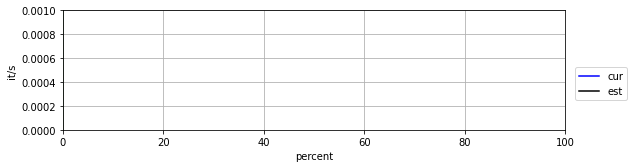

In [ ]:
results = search(query)
results

In [ ]:
results["revisions_per_pageview"] = results.apply(lambda k: k["recent_revisions"] / max(1, k["pageview_avg"]), axis=1)

In [ ]:
results["length_per_pageview"] = results.apply(lambda k: k["length"] / max(1, k["pageview_avg"]), axis=1)

In [ ]:
results["editors_per_revision"] = results.apply(lambda k: len(set([l.get("user") for l in k["revisions"]])) / max(1, k["recent_revisions"]), axis=1)

## Analysis

#### General distributions

This table provides a general overview of the data pulled from Wikipedia. Remember that the pages found are _not_ representative of the search query; they are influenced by the chosen `sort_order`!

In [ ]:
results.describe()

,pageid,ns,index,lastrevid,length,recent_revisions,pageview_avg,revisions_per_pageview,length_per_pageview,editors_per_revision
count,1.000000e+02,100.0,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.072786e+07,0.0,50.500000,9.468839e+08,5915.400000,0.320000,2.756500,0.138949,3553.599471,11.321667
std,1.147297e+07,0.0,29.011492,5.478817e+07,4135.281344,0.886259,3.647847,0.479244,3164.444755,8.474669
min,3.250102e+06,0.0,1.000000,7.235761e+08,1089.000000,0.000000,0.233333,0.000000,327.836153,0.500000
25%,4.391496e+07,0.0,25.750000,9.347146e+08,3038.000000,0.000000,0.850000,0.000000,1334.142857,5.000000
50%,4.833057e+07,0.0,50.500000,9.684669e+08,4738.000000,0.000000,1.333333,0.000000,2706.097052,9.500000
75%,6.156272e+07,0.0,75.250000,9.799381e+08,7542.500000,0.000000,3.220833,0.000000,4890.461538,15.000000
max,6.569689e+07,0.0,100.000000,9.886539e+08,19975.000000,6.000000,18.800000,4.000000,19199.000000,39.000000


### Length Distribution

This chart shows the general distribution of the pages' length (in characters).

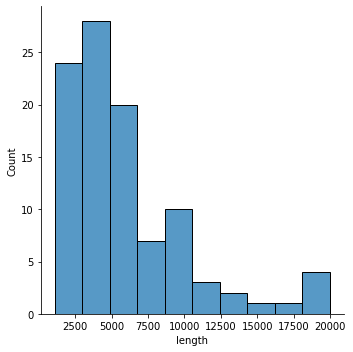

In [ ]:
sns.displot(results["length"])

### Revision Distribution

This chart shows the general distribution of the number of recent revisions (past 30 days).

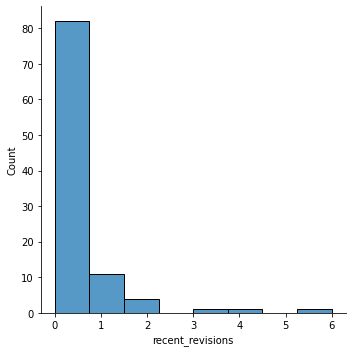

In [ ]:
sns.displot(results["recent_revisions"])

### Pageview Distribution

This chart shows the general distribution of the number of pageviews the pages received (the exact number of days is determined by Wikipedia, but it is guaranteed to be internally consistent).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


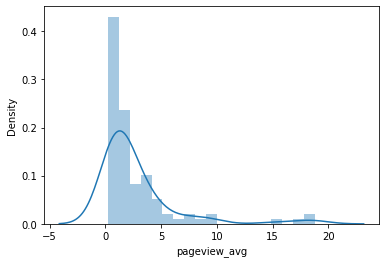

In [ ]:
sns.distplot(results["pageview_avg"])

### Relationship between pageviews and revisions

This chart shows the general relationship between pageviews and number of recent revisions. It can help reveal outliers (pages with significantly higher ratios of revisions to pageviews are notable).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


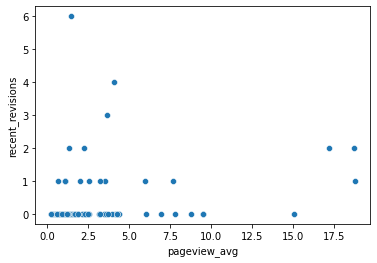

In [ ]:
sns.scatterplot(results["pageview_avg"], results["recent_revisions"])

### Relationship between pageviews and length

This chart shows the general relationship between pageviews and page length. It can help reveal outliers (pages with significantly higher ratios of length to pageviews are notable).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


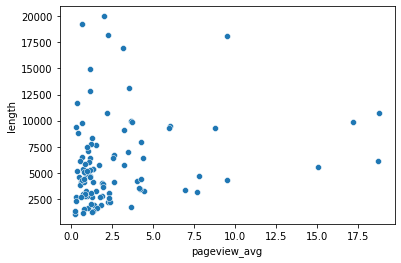

In [ ]:
sns.scatterplot(results["pageview_avg"], results["length"])

### Worth Checking Manually

#### Highest edits-to-pageview ratio

In [ ]:
results.sort_values("revisions_per_pageview", ascending=False).head()

,pageid,ns,title,index,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,pageprops,revisions,recent_revisions,pageview_avg,link,description,descriptionsource,new,revisions_per_pageview,length_per_pageview,editors_per_revision
32,65696886,0,Frederick M. Padilla,100,wikitext,en,en,ltr,2020-11-06T21:17:05Z,986924689,7730,"{'defaultsort': 'Padilla, Frederick M.', 'page...","[{'revid': 986924689, 'parentid': 985793159, '...",6,1.500000,"<a href=""https://en.wikipedia.org/?curid=65696...",U.S. Marine major general.,local,NaN,4.000000,5153.333333,0.5
70,62850100,0,Norman H. Smith,61,wikitext,en,en,ltr,2020-11-06T05:51:05Z,985839515,5406,"{'defaultsort': 'Smith, Norman H.', 'page_imag...","[{'revid': 985839515, 'parentid': 985839451, '...",2,1.333333,"<a href=""https://en.wikipedia.org/?curid=62850...",NaN,NaN,NaN,1.500000,4054.500000,2.0
69,62793267,0,Natalia Boytsun,47,wikitext,en,en,ltr,2020-11-08T22:54:32Z,987736732,19199,"{'defaultsort': 'Boytsun, Natalia', 'wikibase_...","[{'revid': 987736732, 'parentid': 980713105, '...",1,0.650000,"<a href=""https://en.wikipedia.org/?curid=62793...",NaN,NaN,NaN,1.000000,19199.000000,13.0
39,64956945,0,James C. Dawkins Jr.,71,wikitext,en,en,ltr,2020-11-08T17:31:47Z,986201785,3563,"{'defaultsort': 'Dawkins, James C. Jr.', 'page...","[{'revid': 986201785, 'parentid': 986181827, '...",4,4.116667,"<a href=""https://en.wikipedia.org/?curid=64956...",U.S. Air Force lieutenant general,local,NaN,0.971660,865.506073,1.0
94,63412966,0,Victor Begg,82,wikitext,en,en,ltr,2020-11-07T17:15:34Z,987529796,14945,"{'page_image_free': 'Begg,_Author_and_philanth...","[{'revid': 987529796, 'parentid': 976593676, '...",1,1.116667,"<a href=""https://en.wikipedia.org/?curid=63412...",NaN,NaN,NaN,0.895522,13383.582090,12.0


#### Highest length-per-pageview ratio

In [ ]:
results.sort_values("length_per_pageview", ascending=False).head()

,pageid,ns,title,index,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,pageprops,revisions,recent_revisions,pageview_avg,link,description,descriptionsource,new,revisions_per_pageview,length_per_pageview,editors_per_revision
69,62793267,0,Natalia Boytsun,47,wikitext,en,en,ltr,2020-11-08T22:54:32Z,987736732,19199,"{'defaultsort': 'Boytsun, Natalia', 'wikibase_...","[{'revid': 987736732, 'parentid': 980713105, '...",1,0.650000,"<a href=""https://en.wikipedia.org/?curid=62793...",NaN,NaN,NaN,1.000000,19199.000000,13.0
94,63412966,0,Victor Begg,82,wikitext,en,en,ltr,2020-11-07T17:15:34Z,987529796,14945,"{'page_image_free': 'Begg,_Author_and_philanth...","[{'revid': 987529796, 'parentid': 976593676, '...",1,1.116667,"<a href=""https://en.wikipedia.org/?curid=63412...",NaN,NaN,NaN,0.895522,13383.582090,12.0
76,46200930,0,Rafael Resnick Brenner,2,wikitext,en,en,ltr,2020-11-06T05:09:08Z,901376805,11716,"{'defaultsort': 'Resnick Brenner, Rafael', 'wi...","[{'revid': 901376805, 'parentid': 718869176, '...",0,0.333333,"<a href=""https://en.wikipedia.org/?curid=46200...",NaN,NaN,NaN,0.000000,11716.000000,5.0
56,43258977,0,Lamar Sternad,50,wikitext,en,en,ltr,2020-11-06T04:58:06Z,942110522,12820,"{'defaultsort': 'Sternad, Lamar', 'page_image_...","[{'revid': 942110522, 'parentid': 882289445, '...",0,1.166667,"<a href=""https://en.wikipedia.org/?curid=43258...",NaN,NaN,NaN,0.000000,10988.571429,30.0
30,45062095,0,Faizullah Kakar,55,wikitext,en,en,ltr,2020-11-09T15:50:16Z,987073466,19975,"{'defaultsort': 'Kakar, Faizullah', 'wikibase_...","[{'revid': 987073466, 'parentid': 965293343, '...",1,2.016667,"<a href=""https://en.wikipedia.org/?curid=45062...",NaN,NaN,NaN,0.495868,9904.958678,26.0


#### Lowest editors per revision

In [ ]:
results.sort_values("editors_per_revision", ascending=True).head()

,pageid,ns,title,index,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,pageprops,revisions,recent_revisions,pageview_avg,link,description,descriptionsource,new,revisions_per_pageview,length_per_pageview,editors_per_revision
32,65696886,0,Frederick M. Padilla,100,wikitext,en,en,ltr,2020-11-06T21:17:05Z,986924689,7730,"{'defaultsort': 'Padilla, Frederick M.', 'page...","[{'revid': 986924689, 'parentid': 985793159, '...",6,1.500000,"<a href=""https://en.wikipedia.org/?curid=65696...",U.S. Marine major general.,local,NaN,4.00000,5153.333333,0.5
39,64956945,0,James C. Dawkins Jr.,71,wikitext,en,en,ltr,2020-11-08T17:31:47Z,986201785,3563,"{'defaultsort': 'Dawkins, James C. Jr.', 'page...","[{'revid': 986201785, 'parentid': 986181827, '...",4,4.116667,"<a href=""https://en.wikipedia.org/?curid=64956...",U.S. Air Force lieutenant general,local,NaN,0.97166,865.506073,1.0
12,46724623,0,Bruce Beran,38,wikitext,en,en,ltr,2020-11-06T05:11:05Z,935815463,1089,"{'defaultsort': 'Beran, Bruce', 'page_image_fr...","[{'revid': 935815463, 'parentid': 662659977, '...",0,0.233333,"<a href=""https://en.wikipedia.org/?curid=46724...",NaN,NaN,NaN,0.00000,1089.000000,1.0
7,61638277,0,Bob Mead,28,wikitext,en,en,ltr,2020-11-06T05:48:00Z,913117363,2735,"{'defaultsort': 'Mead, Bob', 'wikibase_item': ...","[{'revid': 913117363, 'parentid': 0, 'user': '...",0,0.300000,"<a href=""https://en.wikipedia.org/?curid=61638...",NaN,NaN,,0.00000,2735.000000,1.0
43,62536728,0,John A. Corder,9,wikitext,en,en,ltr,2020-11-06T05:50:27Z,931622387,6519,"{'defaultsort': 'Corder, John A.', 'wikibase_i...","[{'revid': 931622387, 'parentid': 929962855, '...",0,0.650000,"<a href=""https://en.wikipedia.org/?curid=62536...",NaN,NaN,NaN,0.00000,6519.000000,2.0


#### Shortest length

In [ ]:
results.sort_values("length", ascending=True).head()

,pageid,ns,title,index,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,pageprops,revisions,recent_revisions,pageview_avg,link,description,descriptionsource,new,revisions_per_pageview,length_per_pageview,editors_per_revision
12,46724623,0,Bruce Beran,38,wikitext,en,en,ltr,2020-11-06T05:11:05Z,935815463,1089,"{'defaultsort': 'Beran, Bruce', 'page_image_fr...","[{'revid': 935815463, 'parentid': 662659977, '...",0,0.233333,"<a href=""https://en.wikipedia.org/?curid=46724...",NaN,NaN,NaN,0.0,1089.000000,1.0
80,46785063,0,Robert M. Elton,31,wikitext,en,en,ltr,2020-11-06T05:11:16Z,979355685,1163,"{'defaultsort': 'Elton, Robert', 'page_image_f...","[{'revid': 979355685, 'parentid': 935808966, '...",0,0.733333,"<a href=""https://en.wikipedia.org/?curid=46785...",NaN,NaN,NaN,0.0,1163.000000,5.0
96,46785086,0,William H. Reno,14,wikitext,en,en,ltr,2020-11-06T05:11:16Z,979462853,1268,"{'defaultsort': 'Reno, William', 'page_image_f...","[{'revid': 979462853, 'parentid': 935808395, '...",0,1.283333,"<a href=""https://en.wikipedia.org/?curid=46785...",NaN,NaN,NaN,0.0,988.051948,4.0
95,62688557,0,Ward Franz,96,wikitext,en,en,ltr,2020-11-06T05:50:49Z,941155915,1343,"{'defaultsort': 'Franz, Ward', 'wikibase-short...","[{'revid': 941155915, 'parentid': 932991921, '...",0,0.250000,"<a href=""https://en.wikipedia.org/?curid=62688...",American politician,local,NaN,0.0,1343.000000,3.0
79,46785055,0,Robert G. Yerks,18,wikitext,en,en,ltr,2020-11-06T05:11:16Z,979355250,1344,"{'defaultsort': 'Yerks, Robert', 'wikibase_ite...","[{'revid': 979355250, 'parentid': 725587717, '...",0,1.316667,"<a href=""https://en.wikipedia.org/?curid=46785...",NaN,NaN,NaN,0.0,1020.759494,5.0


#### Fewest pageviews

In [ ]:
results.sort_values("pageview_avg", ascending=True).head()

,pageid,ns,title,index,contentmodel,pagelanguage,pagelanguagehtmlcode,pagelanguagedir,touched,lastrevid,length,pageprops,revisions,recent_revisions,pageview_avg,link,description,descriptionsource,new,revisions_per_pageview,length_per_pageview,editors_per_revision
12,46724623,0,Bruce Beran,38,wikitext,en,en,ltr,2020-11-06T05:11:05Z,935815463,1089,"{'defaultsort': 'Beran, Bruce', 'page_image_fr...","[{'revid': 935815463, 'parentid': 662659977, '...",0,0.233333,"<a href=""https://en.wikipedia.org/?curid=46724...",NaN,NaN,NaN,0.0,1089.0,1.0
95,62688557,0,Ward Franz,96,wikitext,en,en,ltr,2020-11-06T05:50:49Z,941155915,1343,"{'defaultsort': 'Franz, Ward', 'wikibase-short...","[{'revid': 941155915, 'parentid': 932991921, '...",0,0.250000,"<a href=""https://en.wikipedia.org/?curid=62688...",American politician,local,NaN,0.0,1343.0,3.0
7,61638277,0,Bob Mead,28,wikitext,en,en,ltr,2020-11-06T05:48:00Z,913117363,2735,"{'defaultsort': 'Mead, Bob', 'wikibase_item': ...","[{'revid': 913117363, 'parentid': 0, 'user': '...",0,0.300000,"<a href=""https://en.wikipedia.org/?curid=61638...",NaN,NaN,,0.0,2735.0,1.0
40,64166659,0,James N. Baldwin,25,wikitext,en,en,ltr,2020-11-06T05:54:55Z,964121561,2352,"{'defaultsort': 'Baldwin, James N.', 'wikibase...","[{'revid': 964121561, 'parentid': 964120334, '...",0,0.316667,"<a href=""https://en.wikipedia.org/?curid=64166...",NaN,NaN,NaN,0.0,2352.0,5.0
87,64230139,0,Stephen Nadeau,10,wikitext,en,en,ltr,2020-11-08T08:49:03Z,970705479,9369,"{'defaultsort': 'Nadeau, Stephen', 'wikibase-s...","[{'revid': 970705479, 'parentid': 970705174, '...",0,0.316667,"<a href=""https://en.wikipedia.org/?curid=64230...",American behavioral neurologist,local,NaN,0.0,9369.0,5.0
